# Problem Set 6, due Nov 19 at 11:59pm.


## Part 1: Exploring the Titanic

Your mission for this problem set is to use your knowledge of supervised machine learning to try to predict which passengers aboard the Titanic were most likely to survive. The prompts for this part of the problem set are deliberately vague - the goal is to leave it up to you how to structure (most of) your analysis.

To get started, read about the prediction problem on [Kaggle](https://www.kaggle.com/c/titanic). Then, download the data [here](https://www.kaggle.com/c/titanic/data) - you'll at the very least need the train.csv data.

> <font color='red'>Some helpful information from the website above:</font>

| Variable | Definition | Key |
|----------|------------|-----|
| survival | Survival | 0 = No, 1 = Yes |
| pclass | Ticket class | 1 = 1st, 2 = 2nd, 3 = 3rd |
| sex | Sex | |
| Age | Age | in years |
| sibsp | # of siblings / spouses aboard the Titanic | |
| parch | # of parents / children aboard the Titanic | |
| ticket | Ticket number | |
| fare | Passenger fare | |
| cabin | Cabin number | |
| embarked | Port of Embarkation | C = Cherbourg, Q = Queenstown, S = Southampton |

**Variable Notes**

pclass: A proxy for socio-economic status (SES)
* 1st = Upper
* 2nd = Middle
* 3rd = Lower

age: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

sibsp: The dataset defines family relations in this way...
* Sibling = brother, sister, stepbrother, stepsister
* Spouse = husband, wife (mistresses and fiancés were ignored)

parch: The dataset defines family relations in this way...
* Parent = mother, father
* Child = daughter, son, stepdaughter, stepson
* Some children travelled only with a nanny, therefore parch=0 for them.

### 1.1 Exploratory data analysis

Create 2-3 figures and tables that help give you a feel for the data. Make sure to at least check the data type of each variable, to understand which variables have missing observations, and to understand the distribution of each variable (and determine whether the variables should be normalized or not). Are any of the potential predictor variables (i.e., anything execpt for survival) collinear or highly correlated? 

> <font color='red'>Import necessary modules:</font>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
from scipy import stats

> <font color='red'>Read in data files:</font>

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

> <font color='red'>Get a sense of the training dataframe using the `DataFrame.info()` method:</font>

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


> <font color='red'>Convert `Sex` numeric, with:
> * male = 0, female = 1</font>

In [4]:
# Sex
numeric_Sex = np.array([])
for i in range(len(train.index)):
    if train['Sex'][i] == 'male':
        numeric_Sex = np.append(numeric_Sex, 0)
    else:
        numeric_Sex = np.append(numeric_Sex, 1)
        
train['Sex'] = numeric_Sex.astype(np.int64)

> <font color='red'>Convert `Embarked` into three binary categories:</font>

In [5]:
# embarked
for i in range(len(train.index)):
    if train['Embarked'][i] == 'C':
        train.loc[i, 'Embarked_C'] = 1
        train.loc[i, 'Embarked_Q'] = 0
        train.loc[i, 'Embarked_S'] = 0
    elif train['Embarked'][i] == 'Q':
        train.loc[i, 'Embarked_C'] = 0
        train.loc[i, 'Embarked_Q'] = 1
        train.loc[i, 'Embarked_S'] = 0
    elif train['Embarked'][i] == 'S':
        train.loc[i, 'Embarked_C'] = 0
        train.loc[i, 'Embarked_Q'] = 0
        train.loc[i, 'Embarked_S'] = 1
    else:
        train.loc[i, 'Embarked_C'] = np.nan
        train.loc[i, 'Embarked_Q'] = np.nan
        train.loc[i, 'Embarked_S'] = np.nan
        
# drop the original row
train.drop(columns=['Embarked'], inplace=True)

> <font color='red'>Get a sense of the range and distribution of the variables using the `DataFrame.describe()` and `pandas.plotting.scatter_matrix()` methods:</font>

In [6]:
train.describe()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S
count,891.000000,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000,889.000000,889.000000,889.000000
mean,446.000000,0.383838,2.308642,0.352413,29.699118,0.523008,0.381594,32.204208,0.188976,0.086614,0.724409
std,257.353842,0.486592,0.836071,0.477990,14.526497,1.102743,0.806057,49.693429,0.391710,0.281427,0.447063
min,1.000000,0.000000,1.000000,0.000000,0.420000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,0.000000,20.125000,0.000000,0.000000,7.910400,0.000000,0.000000,0.000000
50%,446.000000,0.000000,3.000000,0.000000,28.000000,0.000000,0.000000,14.454200,0.000000,0.000000,1.000000
75%,668.500000,1.000000,3.000000,1.000000,38.000000,1.000000,0.000000,31.000000,0.000000,0.000000,1.000000
max,891.000000,1.000000,3.000000,1.000000,80.000000,8.000000,6.000000,512.329200,1.000000,1.000000,1.000000


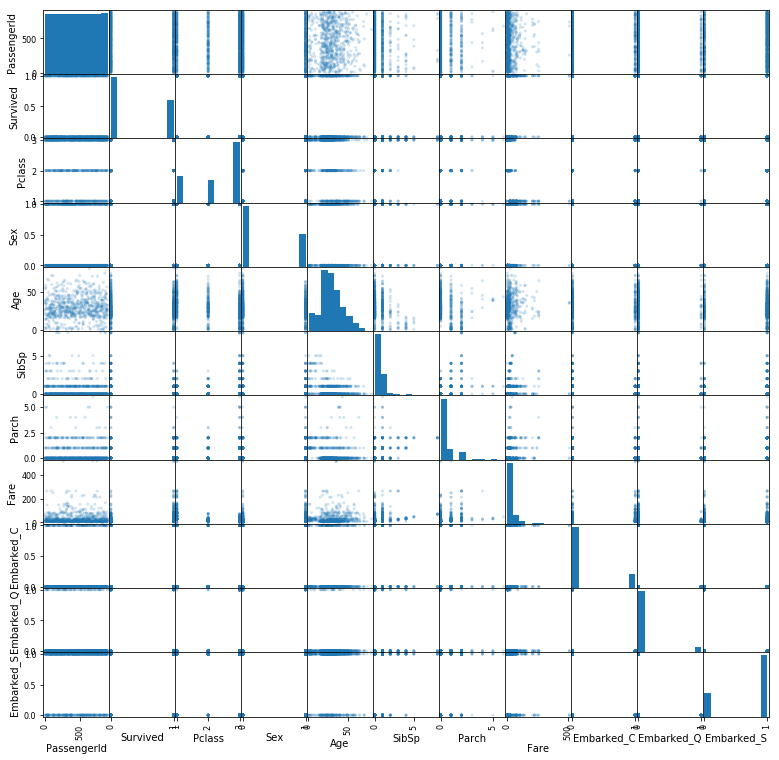

In [7]:
fig = pd.plotting.scatter_matrix(train, figsize=(13,13), alpha=0.2)

> <font color='red'>As we can see from the scatterplot matrix and summary tables above, `Age`, `Cabin`, and `Embarked` have missing data. Clearly, the data needs to be normalized in order to prevent overweighting of any single variable, since the range of values is very different depending on the category. Finally, the scatter plots above do not reveal any obvious strong collinearity among predictor variables. However, we do observe slight to moderate collinearity between `Age` and `SibSp` (which makes sense, since typically you travel with your siblings when you are young, but only your partner as you get older), between `Age` and `Parch` (which makes sense, because you can only have a maximum of two parents when you are young, but you can have any number of children when you are old), between `Pclass` and `Fare` (which makes sense, because upper class tickets are more expensive), between `Fare` and `SibSp` (which makes sense, since wealthy families tend to have smaller families), and between `Fare` and `Parch` (which makes sense, again since wealthy families tend to have smaller families).</font>

### 1.2 Correlates of survival

Use whatever methods you can think of to try and figure out what factors seem to determine whether or not a person would survive the sinking of the Titanic. What do you conclude?

> <font color='red'>I choose to simply implement a t-test between survivors and non-survivors for each variable. This method does not identify collinearity, but does provide a first-order prediction as to what factors correlate with survival.</font>

In [8]:
# import necessary module
from scipy import stats

# variables we want to test
ttest_vars = ['PassengerId','Pclass','Sex','Age','SibSp','Parch','Fare','Embarked_C','Embarked_Q','Embarked_S']

# separate survived and non-survived
train_survived_0 = train[train['Survived']==0].copy()
train_survived_1 = train[train['Survived']==1].copy()

# storage vectors
stat_vec = np.zeros(len(ttest_vars))
pval_vec = np.zeros(len(ttest_vars))
pass_vec = []

# iterate through the variables
for i in range(len(ttest_vars)):
    
    # do the t-test, dropping empty rows
    stat, pval = stats.ttest_ind(train_survived_0[ttest_vars[i]].dropna(),
                                 train_survived_1[ttest_vars[i]].dropna(),
                                 equal_var=False)
    
    # store
    stat_vec[i] = stat
    pval_vec[i] = pval
    if pval < 0.05:
        pass_vec.append(True)
    else:
        pass_vec.append(False)
    
# create a table
ttest_df = pd.DataFrame({'variable':ttest_vars,'stat':stat_vec,'pval':pval_vec,'significant?':pass_vec})
ttest_df

,variable,stat,pval,significant?
0,PassengerId,0.150406,8.804853e-01,False
1,Pclass,10.336953,2.911155e-23,True
2,Sex,-18.134563,1.243794e-58,True
3,Age,2.046030,4.118965e-02,True
4,SibSp,1.194353,2.326626e-01,False
5,Parch,-2.478908,1.339484e-02,True
6,Fare,-6.839099,2.699332e-11,True
7,Embarked_C,-4.836518,1.691747e-06,True
8,Embarked_Q,-0.134635,8.929382e-01,False
9,Embarked_S,4.420475,1.156630e-05,True


> <font color='red'>As we can see from the results of the t-test above, many of the variables seem to be significantly correlated (at the 95% confidence level) with survival. In particular, `Pclass`, `Sex`, `Age`, `Parch`, `Fare`, `Embarked_C`, and `Embarked_S` all correlate with survival. However, as discussed in part 1.1, we can see that several of these variables are correlated with one another, so it is not clear from this analysis alone which of these variables are actually 'causal' for survival.</font>

## Part 2: Decision Trees
### 2.1 Decision Tree
Using the basic [Decision Tree](http://scikit-learn.org/stable/modules/tree.html#tree) library in sklearn, fit a model to predict titanic survival. Make sure you come up with an appropriate way of handling each of the input variables before feeding them in to the decision tree. You can use the [DecisionTreeClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier) method to implement 10-fold cross-validation.

For this any the following problems, you should set aside some of your training data as held-out test data, prior to cross-validation. Report the average training and testing accuracy across your 10 folds, and show a diagram of the tree (at least the first three levels). Finally, select the best-performing decision tree (i.e., the one that achieved the highest cross-validated performance) and report the performance of the fitted model on the held-out test data -- how does it compare to the cross-validated accuracy?

> <font color='red'>Get rid of useless columns:</font>

In [9]:
# columns that we actually want
keep_vars = ['PassengerId','Pclass','Sex','Age','SibSp','Parch','Fare','Embarked_C','Embarked_Q','Embarked_S',
             'Survived']
train = train[keep_vars]

> <font color='red'>A function for normalizing, slightly modified from problem set 3:</font>

In [10]:
def normalize(array):
    """
    Normalize an array

    Parameters
    ----------
    array : array
        Original array.

    Returns
    -------
    norm_array : array
        Normalized input array.
    """
    # if the array is just one variable
    if array.ndim==1:
        norm_array = (array - np.nanmean(array))/np.nanstd(array)
        
    # if more than one variable
    else:
        norm_array = (array - np.nanmean(array, axis=0))/np.nanstd(array, axis=0)
    
    return norm_array

> <font color='red'>Normalize everything except for the target, and drop rows with NaN for now:</font>

In [11]:
# normalize
train_norm = train.copy()
for col in train.columns:
    if col!='Survived':
        train_norm[col] = normalize(train[col].values)
        
# drop NaNs
train_norm.dropna(inplace=True)
train_norm.reset_index(drop=True, inplace=True)

> <font color='red'>Also change `Survived` into -1 and 1, for input into `DecisionTreeClassifier`:</font>

In [12]:
for i in range(len(train_norm.index)):
    if train_norm['Survived'][i] == 0:
        train_norm.loc[i, 'Survived'] = -1

> <font color='red'>Split into training and testing:</font>

In [13]:
#import necessary module
from sklearn.model_selection import train_test_split

# get X and Y
feature_names = ['PassengerId','Pclass','Sex','Age','SibSp','Parch','Fare','Embarked_C','Embarked_Q','Embarked_S']
X = train_norm[feature_names].values
Y = train_norm['Survived'].values

# training and testing
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=np.random.seed(22))

> <font color='red'>A function for calculating accuracy:</font>

In [14]:
def compute_accuracy(predicted, observed):
    """
    Compute accuracy.

    Parameters
    ----------
    predicted : array
        Predicted values.
        
    observed : array
        Observed values.

    Returns
    -------
    accuracy : float
        The accuracy.
    """
    TP = sum((predicted==1) & (observed==1))
    TN = sum((predicted==-1) & (observed==-1))
    FP = sum((predicted==1) & (observed==-1))
    FN = sum((predicted==-1) & (observed==1))
    
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    return accuracy

> <font color='red'>The decision tree with cross-validation:</font>

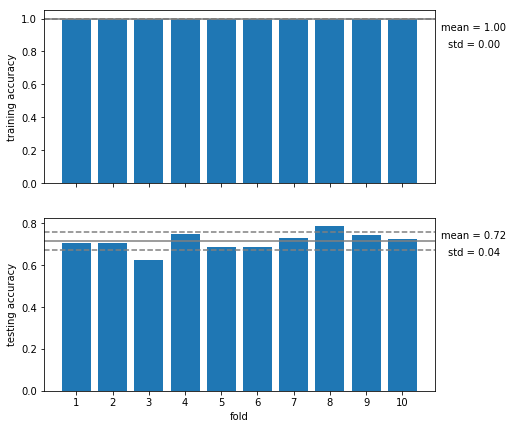

In [15]:
# import necessary modules
from sklearn import tree
from sklearn.model_selection import KFold

# set up the 10-fold cross validation
kf = KFold(n_splits=10, shuffle=True, random_state=np.random.seed(22))

# get the training and testing indexes
kf_train_inds = []
kf_test_inds = []
for kf_train_ind, kf_test_ind in kf.split(X_train):
    kf_train_inds.append(kf_train_ind)
    kf_test_inds.append(kf_test_ind)
    
# storage vectors
kf_train_accuracies = np.zeros(10)
kf_test_accuracies = np.zeros(10)

# iterate through folds
for i in range(10):
    
    # fit the tree
    clf = tree.DecisionTreeClassifier()
    clf = clf.fit(X_train[kf_train_inds[i]], Y_train[kf_train_inds[i]])
    
    # predicted values
    Y_kf_train_predicted = clf.predict(X_train[kf_train_inds[i]])
    Y_kf_test_predicted = clf.predict(X_train[kf_test_inds[i]])
    
    # accuracies
    kf_train_accuracies[i] = compute_accuracy(Y_kf_train_predicted, Y_train[kf_train_inds[i]])
    kf_test_accuracies[i] = compute_accuracy(Y_kf_test_predicted, Y_train[kf_test_inds[i]])
    
# plot the results
fig, ax = plt.subplots(ncols=1, nrows=2, figsize=(7,7), sharex=True)

ax[0].bar(np.arange(10)+1, kf_train_accuracies)
mean_kf_train_accuracies = np.mean(kf_train_accuracies)
std_kf_train_accuracies = np.std(kf_train_accuracies)
ax[0].axhline(mean_kf_train_accuracies, c='C7')
ax[0].axhline(mean_kf_train_accuracies+std_kf_train_accuracies, c='C7', ls='--')
ax[0].axhline(mean_kf_train_accuracies-std_kf_train_accuracies, c='C7', ls='--')
ax[0].text(1.1,0.9,'mean = {:.2f}'.format(mean_kf_train_accuracies),
           horizontalalignment='center', verticalalignment='center', transform=ax[0].transAxes)
ax[0].text(1.1,0.8,'std = {:.2f}'.format(std_kf_train_accuracies),
           horizontalalignment='center', verticalalignment='center', transform=ax[0].transAxes)
ax[0].set_ylabel('training accuracy')

ax[1].bar(np.arange(10)+1, kf_test_accuracies)
mean_kf_test_accuracies = np.mean(kf_test_accuracies)
std_kf_test_accuracies = np.std(kf_test_accuracies)
ax[1].axhline(mean_kf_test_accuracies, c='C7')
ax[1].axhline(mean_kf_test_accuracies+std_kf_test_accuracies, c='C7', ls='--')
ax[1].axhline(mean_kf_test_accuracies-std_kf_test_accuracies, c='C7', ls='--')
ax[1].text(1.1,0.9,'mean = {:.2f}'.format(mean_kf_test_accuracies),
           horizontalalignment='center', verticalalignment='center', transform=ax[1].transAxes)
ax[1].text(1.1,0.8,'std = {:.2f}'.format(std_kf_test_accuracies),
           horizontalalignment='center', verticalalignment='center', transform=ax[1].transAxes)
ax[1].set_ylabel('testing accuracy')
ax[1].set_xlabel('fold')
ax[1].set_xticks(np.arange(10)+1)

plt.show(fig)

> <font color='red'>I was a little confused by what this question was asking... above, I split the training data into 10 folds, and for each of the iterations in the cross-validation I fit a new decision tree to 9 of these folds. This created 10 decision trees, which perfectly predicted the training folds on each iteration, but did variably well for the testing fold on each iteration. Therefore I take "the best perfoming decision tree" to be the one that achieved the highest accuracy on its testing fold (0.79), which in this case ends up being fold 8. Now I use that tree to predict values on the held-out (testing) data:</font>

In [16]:
# fit the tree on fold 8
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train[kf_train_inds[7]], Y_train[kf_train_inds[7]])

# predict on the held-out data
Y_test_predicted = clf.predict(X_test)

# accuracy
accuracy = compute_accuracy(Y_test_predicted, Y_test)
print('accuracy on held-out data = {:.2f}'.format(accuracy))

accuracy on held-out data = 0.75


> <font color='red'>As we can see, the model does worse on the held-out test data compared to the testing fold. Now plot that tree (only showing to a depth of 3):</font>

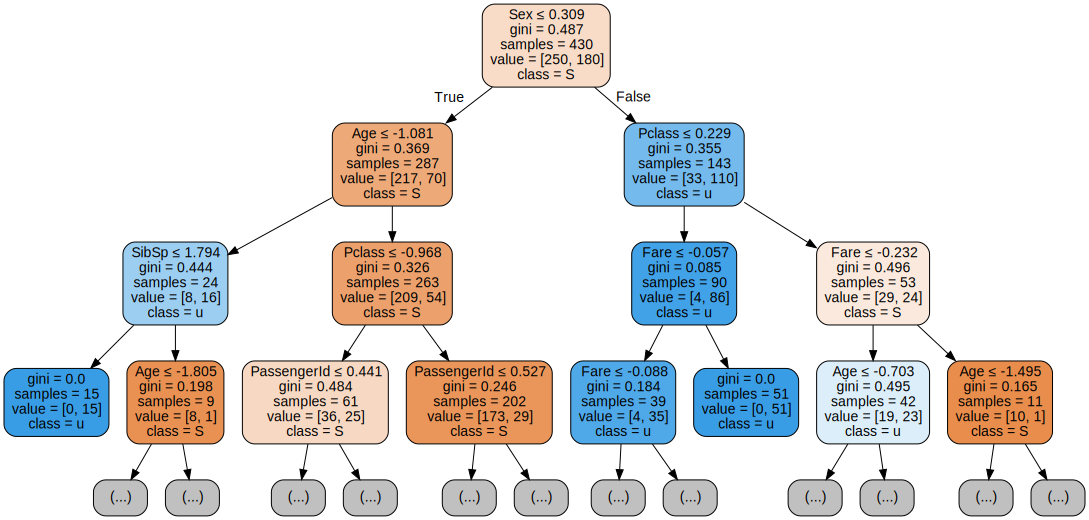

In [17]:
import graphviz
dot_data = tree.export_graphviz(clf, out_file=None, max_depth=3,
                                feature_names=feature_names,class_names='Survived',
                                filled=True, rounded=True, special_characters=True)
graph = graphviz.Source(dot_data)
graph

### 2.2 Tree tuning

Use all of the data (minus the held-out data) to re-fit a single decision tree with max_depth = 4 (i.e., no cross-validation). Show the tree diagram and also plot the feature importances. What do you observe?

> <font color='red'>Fit the tree:</font>

In [18]:
# fit the tree with max_depth=4
clf = tree.DecisionTreeClassifier(max_depth=4)
clf = clf.fit(X_train, Y_train)

# predict on the training and held-out data
Y_train_predicted = clf.predict(X_train)
Y_test_predicted = clf.predict(X_test)

# accuracy
train_accuracy = compute_accuracy(Y_train_predicted, Y_train)
test_accuracy = compute_accuracy(Y_test_predicted, Y_test)
print('accuracy on training data = {:.2f}'.format(train_accuracy))
print('accuracy on held-out data = {:.2f}'.format(test_accuracy))

accuracy on training data = 0.83
accuracy on held-out data = 0.84


> <font color='red'>Plot it:</font>

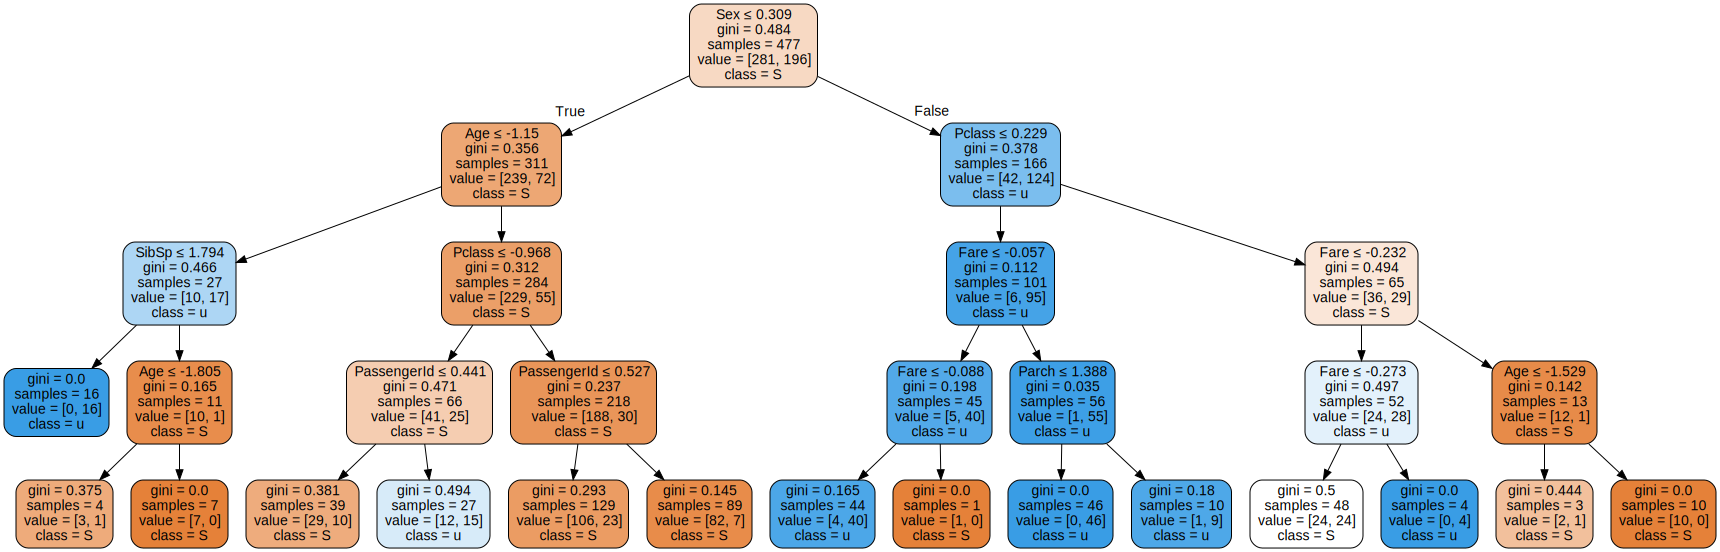

In [19]:
dot_data = tree.export_graphviz(clf, out_file=None,
                                feature_names=feature_names,class_names='Survived',
                                filled=True, rounded=True, special_characters=True)
graph = graphviz.Source(dot_data)
graph

> <font color='red'>Feature importances:</font>

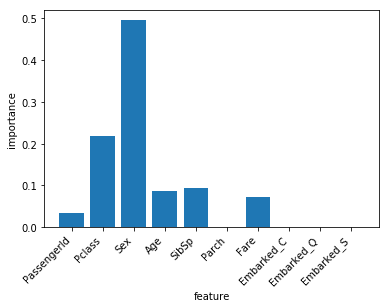

In [20]:
fig, ax = plt.subplots()

ax.bar(np.arange(len(clf.feature_importances_)), clf.feature_importances_)
ax.set_xticks(np.arange(len(clf.feature_importances_)))
ax.set_xticklabels(feature_names, rotation=45, horizontalalignment='right')

ax.set_xlabel('feature')
ax.set_ylabel('importance')

plt.show(fig)

> <font color='red'>The tree with a max depth of 4 performs better on the held-out data than the tree without a max depth (in part 2.1). This is a clear instance of where a deep tree is prone to overfitting the training data, and thus ends up performing worse on the held-out data. Furthermore, we see that in the tree with a max depth of 4, `Sex` is by far the most important factor for determining survival, followed by `Pclass`. So a preliminary conclusion here would be that your gender and wealth were the most important for determining survival. Interestingly, age does not seem to be particularly important.</font>

### 2.3 Sensitivity analysis
The built-in algorithm you are using has several parameters which you can tune. Using cross-validation, show how the choice of these parameters affects performance.

First, show how max_depth affects train and test accuracy. On a single axis, plot train and test accuracy as a function of max_depth. Use a red line to show test accuracy and a blue line to show train accuracy. Do not use your held-out test data.

Second, show how test accuracy relates to both max_depth and min_samples_leaf. Specifically, create a 3-D plot where the x-axis is max_depth, the y-axis is min_samples_leaf, and the z-axis shows accuracy. What combination of max_depth and min-samples_leaf achieves the highest accuracy? How sensitive are the results to these two parameters?

> <font color='red'>From part 2.1, the max depth necessary for node purity is around 15, so we test max depths of 1-15 here:</font>

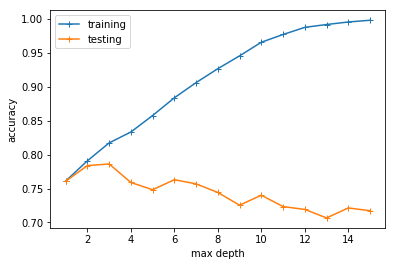

In [21]:
# max depths to test
max_depths = np.arange(1,16)

# storage vectors
train_accuracies = np.zeros(len(max_depths))
test_accuracies = np.zeros(len(max_depths))

# iterate through max depths
for i in range(len(max_depths)):
    
    # storage vectors
    kf_train_accuracies = np.zeros(10)
    kf_test_accuracies = np.zeros(10)
    
    # iterate through folds
    for j in range(10):
        
        # fit the tree
        clf = tree.DecisionTreeClassifier(max_depth=max_depths[i])
        clf = clf.fit(X_train[kf_train_inds[j]], Y_train[kf_train_inds[j]])
        
        # predicted values
        Y_kf_train_predicted = clf.predict(X_train[kf_train_inds[j]])
        Y_kf_test_predicted = clf.predict(X_train[kf_test_inds[j]])

        # accuracies
        kf_train_accuracies[j] = compute_accuracy(Y_kf_train_predicted, Y_train[kf_train_inds[j]])
        kf_test_accuracies[j] = compute_accuracy(Y_kf_test_predicted, Y_train[kf_test_inds[j]])
        
    # store the average
    train_accuracies[i] = np.mean(kf_train_accuracies)
    test_accuracies[i] = np.mean(kf_test_accuracies)
    
# plot
fig, ax = plt.subplots()

ax.plot(max_depths, train_accuracies, '+-', c='C0', label='training')
ax.plot(max_depths, test_accuracies, '+-', c='C1', label='testing')

ax.legend()
ax.set_xlabel('max depth')
ax.set_ylabel('accuracy')

plt.show(fig)

> <font color='red'>As we can see, training accuracy monotonically increases as we increase the max depth of the tree. However, testing accuracy has an approximately convex shape (with some minor deviations) - it increases until a max depth of around 2 or 3, before decreasing. This suggests that a tree with a depth of greater than 2 or 3 overfits the training data.
>
> Next we also test min_samples_leaf:</font>

In [22]:
# min_samples_leaf to test
min_samples_leafs = np.arange(2,51,2)

# storage vectors
train_accuracies = np.zeros((len(max_depths),len(min_samples_leafs)))
test_accuracies = np.zeros((len(max_depths),len(min_samples_leafs)))

# iterate through max depths
for i in tqdm_notebook(range(len(max_depths))):
    
    # iterate through min_samples_leafs
    for j in range(len(min_samples_leafs)):
    
        # storage vectors
        kf_train_accuracies = np.zeros(10)
        kf_test_accuracies = np.zeros(10)
    
        # iterate through folds
        for k in range(10):

            # fit the tree
            clf = tree.DecisionTreeClassifier(max_depth=max_depths[i], min_samples_leaf=min_samples_leafs[j])
            clf = clf.fit(X_train[kf_train_inds[k]], Y_train[kf_train_inds[k]])

            # predicted values
            Y_kf_train_predicted = clf.predict(X_train[kf_train_inds[k]])
            Y_kf_test_predicted = clf.predict(X_train[kf_test_inds[k]])

            # accuracies
            kf_train_accuracies[k] = compute_accuracy(Y_kf_train_predicted, Y_train[kf_train_inds[k]])
            kf_test_accuracies[k] = compute_accuracy(Y_kf_test_predicted, Y_train[kf_test_inds[k]])
        
        # store the average
        train_accuracies[i,j] = np.mean(kf_train_accuracies)
        test_accuracies[i,j] = np.mean(kf_test_accuracies)

best test accuracy = 0.79
  with a max_depth of       = 3
  and a min_samples_leaf of = 4


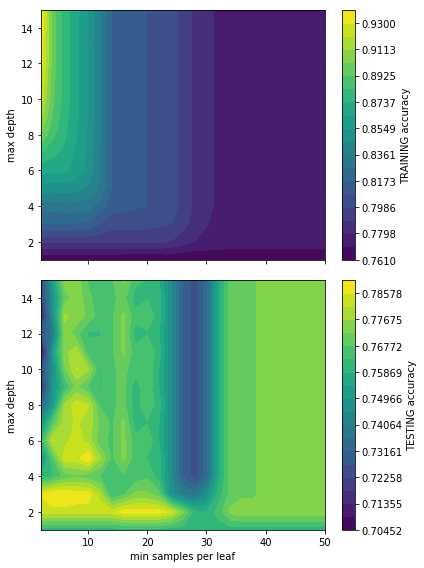

In [23]:
# print some useful numbers
max_ind = np.unravel_index(np.argmax(test_accuracies, axis=None), test_accuracies.shape)
print('best test accuracy = {:.2f}'.format(test_accuracies[max_ind]))
print('  with a max_depth of       = {}'.format(max_depths[max_ind[0]]))
print('  and a min_samples_leaf of = {}'.format(min_samples_leafs[max_ind[1]]))

# plot
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(6,8), sharex=True)

levels = np.linspace(np.min(train_accuracies),np.max(train_accuracies), 20)
cntrf = ax[0].contourf(min_samples_leafs, max_depths, train_accuracies, cmap='viridis', levels=levels)
cbar = fig.colorbar(cntrf, ax=ax[0])
cbar.ax.set_ylabel('TRAINING accuracy')
ax[0].set_ylabel('max depth')

levels = np.linspace(np.min(test_accuracies),np.max(test_accuracies), 20)
cntrf = ax[1].contourf(min_samples_leafs, max_depths, test_accuracies, cmap='viridis', levels=levels)
cbar = fig.colorbar(cntrf, ax=ax[1])
cbar.ax.set_ylabel('TESTING accuracy')
ax[1].set_ylabel('max depth')
ax[1].set_xlabel('min samples per leaf')

fig.tight_layout()
plt.show(fig)

> <font color='red'>As we can see, for the training data, decreasing the minimum samples per leaf and increasing the max depth lead to a higher accuracy. However, for the testing data, there is a point where the tree starts to ovefit the training data. Therefore, we find that the tree that performs the best on the testing data has a max depth of 3 and a minimum samples per leaf of 4. However, the accuracy surface for the testing data is not a perfect convex 3D parabola - instead, there is substantial "noise" which is likely a result of small changes in the tuning parameters leading to a significantly different tree (i.e. splits change significantly due to small changes in the tuning parameters). Nevertheless, a max depth of around 3 and a minimum samples per leaf of around 4 appears to be generally robust.
>
> Plot the best performing tree, and see how it does on the held-out data:</font>

In [24]:
# fit the tree
clf = tree.DecisionTreeClassifier(max_depth=3, min_samples_leaf=4)
clf = clf.fit(X_train, Y_train)

# predict on the held-out data
Y_test_predicted = clf.predict(X_test)

# accuracy
accuracy = compute_accuracy(Y_test_predicted, Y_test)
print('accuracy on held-out data = {:.2f}'.format(accuracy))

accuracy on held-out data = 0.86


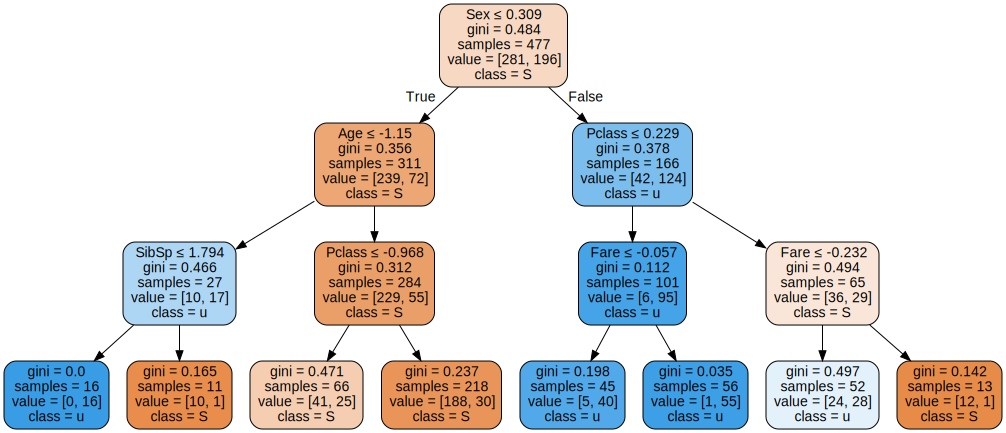

In [25]:
dot_data = tree.export_graphviz(clf, out_file=None,
                                feature_names=feature_names,class_names='Survived',
                                filled=True, rounded=True, special_characters=True)
graph = graphviz.Source(dot_data)
graph

> <font color='red'>This tree has done the best on the held-out test data so far.</font>

### 2.4 Logistic Regression, for comparison
Use a 10-fold cross-validated logistic regression predict survival. Make sure you come up with an appropriate way of handling each of the input variables before feeding them in to the regression. 
* How does the cross-validated test performance of this model compare to the decision tree?
* How do the coefficients from the logistic regression compare to the feature importances from the decision tree? Create a scatter plot that shows this relationship (one dot for each variable, y-axis is feature importance, x-axis is....?)

> <font color='red'>First, do the cross-validation to get the accuracy on the held-out test data (again I'm a little confused here, because we generate 10 different sets of coefficients, so we cannot extract a single set of coefficients here):</font>

In [26]:
# import necessary modules
from sklearn.linear_model import LogisticRegressionCV

# logistic regression with cross validation built in
logreg = LogisticRegressionCV(cv=10, random_state=np.random.seed(22))
logreg = logreg.fit(X_train, Y_train)

# predict on held-out data
Y_test_predicted = logreg.predict(X_test)

# accuracy
accuracy = compute_accuracy(Y_test_predicted, Y_test)
print('accuracy on held-out data = {:.2f}'.format(accuracy))

accuracy on held-out data = 0.84


> <font color='red'>This cross-validated logistic regression does almost as well on the held-out test data as the best performing tree so far.
>
> Next just do a standard logistic regression (without cross-validation) to get a single set of coefficients:</font>

In [27]:
# import necessary modules
from sklearn.linear_model import LogisticRegression

# logistic regression
logreg = LogisticRegression(solver='lbfgs')
logreg = logreg.fit(X_train, Y_train)

# predict on held-out data
Y_test_predicted = logreg.predict(X_test)

# accuracy
accuracy = compute_accuracy(Y_test_predicted, Y_test)
print('accuracy on held-out data = {:.2f}'.format(accuracy))

accuracy on held-out data = 0.84


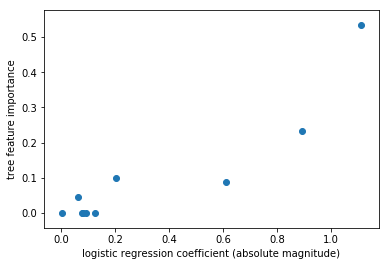

In [28]:
fig, ax = plt.subplots()

ax.scatter(np.abs(logreg.coef_), clf.feature_importances_)
ax.set_xlabel('logistic regression coefficient (absolute magnitude)')
ax.set_ylabel('tree feature importance')

plt.show(fig)

> <font color='red'>As we can see from the above, the feature importances extracted from the decision tree correlate well with the absolute magnitude of the logistic regression coefficients. This makes sense, since the most important features in the decision tree should also have the strongest influence on predicting the target in a logistic regression.</font>

### 2.5 Missing Data
Have you been paying close attention to your features? If not, now is a good time to start. Perform analysis that allows you to answer the following questions:
* Do any of your features have missing data? If so, which ones? What percent of observations have missing data?
* What happens to observations with missing data when you run the decision tree and logistic regression models above?
* Use one of the methods we discussed in class to impute missing values
* Rerun your decision tree and logistic regression on the new dataset with imputed missing values. What do you notice?

* Do any of your features have missing data? If so, which ones? What percent of observations have missing data?

> <font color='red'>Yes - as described in Part 1, `Age` and `Embarked` have missing data.</font>

* What happens to observations with missing data when you run the decision tree and logistic regression models above?

> <font color='red'>I have not shown it here, but the decision tree (at least in the way that I have implemented it) does not work with missing data.</font>

* Use one of the methods we discussed in class to impute missing values

> <font color='red'>For `Age`, I choose to impute missing values by inputting the mean value. However, `Embarked` is categorical, and thus the mean value is meaningless. Therefore, we input the mode value instead.</font>

In [29]:
# impute for Embarked
# the mode is port S - found in part 1
train_norm = train.copy()
for i in range(len(train_norm.index)):
    if ~np.isfinite(train_norm['Embarked_S'][i]):
        train_norm.loc[i, 'Embarked_C'] = 0
        train_norm.loc[i, 'Embarked_Q'] = 0
        train_norm.loc[i, 'Embarked_S'] = 1

# normalize
for col in train.columns:
    if col!='Survived':
        train_norm[col] = normalize(train_norm[col].values)

# convert survived into -1 and 1
for i in range(len(train_norm.index)):
    if train_norm['Survived'][i] == 0:
        train_norm.loc[i, 'Survived'] = -1
        
# impute for Age
mean_Age = np.nanmean(train_norm['Age'])
for i in range(len(train_norm.index)):
    if ~np.isfinite(train_norm['Age'][i]):
        train_norm.loc[i, 'Age'] = mean_Age
        
# get X and Y
feature_names = ['PassengerId','Pclass','Sex','Age','SibSp','Parch','Fare','Embarked_C','Embarked_Q','Embarked_S']
X = train_norm[feature_names].values
Y = train_norm['Survived'].values

# training and testing
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=np.random.seed(22))

In [30]:
# fit the tree
clf = tree.DecisionTreeClassifier(max_depth=3, min_samples_leaf=4)
clf = clf.fit(X_train, Y_train)

# predict on the held-out data
Y_test_predicted = clf.predict(X_test)

# accuracy
accuracy = compute_accuracy(Y_test_predicted, Y_test)
print('accuracy on held-out data = {:.2f}'.format(accuracy))

accuracy on held-out data = 0.80


In [31]:
# logistic regression
logreg = LogisticRegression(solver='lbfgs')
logreg = logreg.fit(X_train, Y_train)

# predict on held-out data
Y_test_predicted = logreg.predict(X_test)

# accuracy
accuracy = compute_accuracy(Y_test_predicted, Y_test)
print('accuracy on held-out data = {:.2f}'.format(accuracy))

accuracy on held-out data = 0.78


* Rerun your decision tree and logistic regression on the new dataset with imputed missing values. What do you notice?

> <font color='red'>The model performs worse with the imputed values. This makes sense in my case, because in effect we made up data and added new rows that includes this made up data to the analysis.</font>

## 2.6 (extra credit): Implement a Decision Tree in Python

Now, put away the canned algorithm from sklearn, and write your own decision tree algorithm. Use the simple recursive algorithm we described in class, and use your algorithm to re-do the analysis in 2.1. Do not worry about implementing bells and whistles. However, you will definitely need the following:
 * A "GrowTree" function that implements the recursive algorithm
 * A function to calculate information gain
 
Implement the minimum required code to build a decision tree. How does your algorithm compare in performance to the sklearn algorithm? What do you think are the main sources of discrepancy? If you had more time, what would you change to improve your algorithm?

> <font color='red'>Sorry... the end of the semester is busy.</font>

## 3: Many Trees

### 3.1: Random Forest
Use the [random forest classifier](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) to predict survival on the titanic. Use cross-validation on the training data to choose the best hyper-parameters. 
* What hyperparameters did you select with cross-validation?
* How does the cross-validated performance (average across validation folds) compare to the test performance (using the top-performing, fitted model selected through cross-validation)?
* How does the RF performance compare to the decision tree and logistic regression?
* Create a plot that shows how cross-validated performance (y-axis) relates to the number of trees in the forest (x-axis).

> <font color='red'>First, go back to the data without imputed values:</font>

In [32]:
# normalize
train_norm = train.copy()
for col in train.columns:
    if col!='Survived':
        train_norm[col] = normalize(train[col].values)
        
# drop NaNs
train_norm.dropna(inplace=True)
train_norm.reset_index(drop=True, inplace=True)

# convert survived into -1 and 1
for i in range(len(train_norm.index)):
    if train_norm['Survived'][i] == 0:
        train_norm.loc[i, 'Survived'] = -1
        
# get X and Y
feature_names = ['PassengerId','Pclass','Sex','Age','SibSp','Parch','Fare','Embarked_C','Embarked_Q','Embarked_S']
X = train_norm[feature_names].values
Y = train_norm['Survived'].values

# training and testing
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=np.random.seed(22))

# set up the 10-fold cross validation
kf = KFold(n_splits=10, shuffle=True, random_state=np.random.seed(22))

# get the training and testing indexes
kf_train_inds = []
kf_test_inds = []
for kf_train_ind, kf_test_ind in kf.split(X_train):
    kf_train_inds.append(kf_train_ind)
    kf_test_inds.append(kf_test_ind)

> <font color='red'>Now do the random forest:</font>

In [33]:
# import module
from sklearn.ensemble import RandomForestClassifier

# n_estimators to test
n_trees = np.arange(2,101)

# storage vectors
train_accuracies = np.zeros(len(n_trees))
test_accuracies = np.zeros(len(n_trees))

# iterate through max depths
for i in tqdm_notebook(range(len(n_trees))):
    
    # storage vectors
    kf_train_accuracies = np.zeros(10)
    kf_test_accuracies = np.zeros(10)
    
    # iterate through folds
    for j in range(10):
        
        # fit the tree
        clf = RandomForestClassifier(n_estimators=n_trees[i], max_depth=3, min_samples_leaf=4,
                                     random_state=np.random.seed(22))
        clf = clf.fit(X_train[kf_train_inds[j]], Y_train[kf_train_inds[j]])
        
        # predicted values
        Y_kf_train_predicted = clf.predict(X_train[kf_train_inds[j]])
        Y_kf_test_predicted = clf.predict(X_train[kf_test_inds[j]])

        # accuracies
        kf_train_accuracies[j] = compute_accuracy(Y_kf_train_predicted, Y_train[kf_train_inds[j]])
        kf_test_accuracies[j] = compute_accuracy(Y_kf_test_predicted, Y_train[kf_test_inds[j]])
        
    # store the average
    train_accuracies[i] = np.mean(kf_train_accuracies)
    test_accuracies[i] = np.mean(kf_test_accuracies)

n trees that performed the best on the testing fold = 18
accuracy of this tree = 0.80


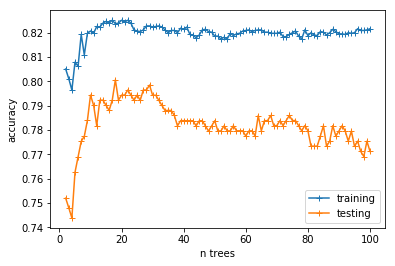

In [34]:
# print useful numbers
max_ind = np.argmax(test_accuracies)
print('n trees that performed the best on the testing fold = {}'.format(n_trees[max_ind]))
print('accuracy of this tree = {:.2f}'.format(test_accuracies[max_ind]))

# plot
fig, ax = plt.subplots()

ax.plot(n_trees, train_accuracies, '+-', c='C0', label='training')
ax.plot(n_trees, test_accuracies, '+-', c='C1', label='testing')

ax.legend()
ax.set_xlabel('n trees')
ax.set_ylabel('accuracy')

plt.show(fig)

> <font color='red'>Now use the best forest to test on the held-out data:</font>

In [35]:
# fit the tree
clf = RandomForestClassifier(n_estimators=18, max_depth=3, min_samples_leaf=4,
                             random_state=np.random.seed(22))
clf = clf.fit(X_train, Y_train)

# predict on the held-out data
Y_test_predicted = clf.predict(X_test)

# accuracy
accuracy = compute_accuracy(Y_test_predicted, Y_test)
print('accuracy on held-out data = {:.2f}'.format(accuracy))

accuracy on held-out data = 0.86


* What hyperparameters did you select with cross-validation?

> <font color='red'>I tuned for the number of trees in the forest. For max depth and the minimimum number of samples per leaf, I used the optimal values found in part 2.3.</font>

* How does the cross-validated performance (average across validation folds) compare to the test performance (using the top-performing, fitted model selected through cross-validation)?

> <font color='red'>The best performing forest does better on the held-out data than on the cross-validated testing folds, which illustrates that the forest generalizes well.</font>

* How does the RF performance compare to the decision tree and logistic regression?

> <font color='red'>The best performing forest does about as well as the best performing decision tree, and slightly better than the logistic regression.</font>

* Create a plot that shows how cross-validated performance (y-axis) relates to the number of trees in the forest (x-axis).

> <font color='red'>See above. After a certain number of trees (around 15), having more trees appears to do little to improve accuracy on either the training or testing folds.</font>

### 3.2: Gradient Boosting

Use the [Gradient Boosting classifier](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html) to predict survival on the Titanic. Tune your hyperparameters. 
* How does the GBM performance compare to the other models?
* Create a figure showing the feature importances in your final model (with properly tuned hyperparameters)

In [36]:
# import module
from sklearn.ensemble import GradientBoostingClassifier

# learning rates to test
learning_rates = np.linspace(0.01,0.5,25)

# storage vectors
train_accuracies = np.zeros(len(learning_rates))
test_accuracies = np.zeros(len(learning_rates))

# iterate through max depths
for i in tqdm_notebook(range(len(learning_rates))):
    
    # storage vectors
    kf_train_accuracies = np.zeros(10)
    kf_test_accuracies = np.zeros(10)
    
    # iterate through folds
    for j in range(10):
        
        # fit the tree
        clf = GradientBoostingClassifier(learning_rate=learning_rates[i], max_depth=3, min_samples_leaf=4,
                                         random_state=np.random.seed(22))
        clf = clf.fit(X_train[kf_train_inds[j]], Y_train[kf_train_inds[j]])
        
        # predicted values
        Y_kf_train_predicted = clf.predict(X_train[kf_train_inds[j]])
        Y_kf_test_predicted = clf.predict(X_train[kf_test_inds[j]])

        # accuracies
        kf_train_accuracies[j] = compute_accuracy(Y_kf_train_predicted, Y_train[kf_train_inds[j]])
        kf_test_accuracies[j] = compute_accuracy(Y_kf_test_predicted, Y_train[kf_test_inds[j]])
        
    # store the average
    train_accuracies[i] = np.mean(kf_train_accuracies)
    test_accuracies[i] = np.mean(kf_test_accuracies)

learning rate that performed the best on the testing fold = 0.01
accuracy of this model = 0.80


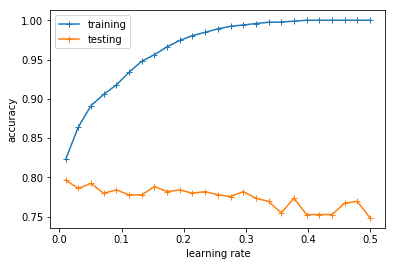

In [37]:
# print useful numbers
max_ind = np.argmax(test_accuracies)
print('learning rate that performed the best on the testing fold = {}'.format(learning_rates[max_ind]))
print('accuracy of this model = {:.2f}'.format(test_accuracies[max_ind]))

# plot
fig, ax = plt.subplots()

ax.plot(learning_rates, train_accuracies, '+-', c='C0', label='training')
ax.plot(learning_rates, test_accuracies, '+-', c='C1', label='testing')

ax.legend()
ax.set_xlabel('learning rate')
ax.set_ylabel('accuracy')

plt.show(fig)

In [38]:
# fit the tree
clf = GradientBoostingClassifier(learning_rate=0.01, max_depth=3, min_samples_leaf=4,
                                 random_state=np.random.seed(22))
clf = clf.fit(X_train, Y_train)

# predict on the held-out data
Y_test_predicted = clf.predict(X_test)

# accuracy
accuracy = compute_accuracy(Y_test_predicted, Y_test)
print('accuracy on held-out data = {:.2f}'.format(accuracy))

accuracy on held-out data = 0.86


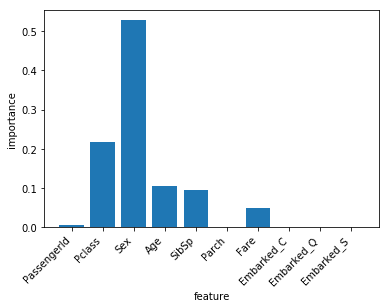

In [39]:
fig, ax = plt.subplots()

ax.bar(np.arange(len(clf.feature_importances_)), clf.feature_importances_)
ax.set_xticks(np.arange(len(clf.feature_importances_)))
ax.set_xticklabels(feature_names, rotation=45, horizontalalignment='right')

ax.set_xlabel('feature')
ax.set_ylabel('importance')

plt.show(fig)

* How does the GBM performance compare to the other models?

> <font color='red'>Again, the best perfoming GBM does about the same on the held-out data when compared to the best performing random forest and decision tree, and slightly better than the logistic regression.</font>

* Create a figure showing the feature importances in your final model (with properly tuned hyperparameters)

> <font color='red'>The feature importances are basically the same as that for the single decision tree.</font>

### 3.3 Feature Engineering
Revisit the features in your dataset.
* Are each of the features being appropriately included in the analysis? 
* Find a way to engineer meaningful features from the "Name" and/or "Cabin" fields in the data.
* Create a final table that summarizes the performance of your models as follows:

| Model | Cross-validated Performance   | Test Performance | 
|------|------|------|
|   Decision Tree        |  |  |
|   Decision Tree (with imputed missing values and new features)        |  |  |
|   Logistic Regression  |  |  |
|   Logistic Regression (with imputed missing values and new features)        |  |  |
|   Random Forest        |  |  |
|   Random Forest (with imputed missing values and new features)        |  |  |
|   Gradient Boosting    |  |  | 
|   Gradient Boosting (with imputed missing values and new features)        |  |   x |


> <font color='red'>Set up the data again:</font>

In [40]:
train = pd.read_csv('train.csv')

# Sex
numeric_Sex = np.array([])
for i in range(len(train.index)):
    if train['Sex'][i] == 'male':
        numeric_Sex = np.append(numeric_Sex, 0)
    else:
        numeric_Sex = np.append(numeric_Sex, 1)
        
train['Sex'] = numeric_Sex.astype(np.int64)

# embarked
for i in range(len(train.index)):
    if train['Embarked'][i] == 'C':
        train.loc[i, 'Embarked_C'] = 1
        train.loc[i, 'Embarked_Q'] = 0
        train.loc[i, 'Embarked_S'] = 0
    elif train['Embarked'][i] == 'Q':
        train.loc[i, 'Embarked_C'] = 0
        train.loc[i, 'Embarked_Q'] = 1
        train.loc[i, 'Embarked_S'] = 0
    elif train['Embarked'][i] == 'S':
        train.loc[i, 'Embarked_C'] = 0
        train.loc[i, 'Embarked_Q'] = 0
        train.loc[i, 'Embarked_S'] = 1
    else:
        train.loc[i, 'Embarked_C'] = np.nan
        train.loc[i, 'Embarked_Q'] = np.nan
        train.loc[i, 'Embarked_S'] = np.nan
        
# drop the original row
train.drop(columns=['Embarked'], inplace=True)

> <font color='red'>For feature engineering, I choose to use the `Cabin` column, and extract the floor/compartment that the individual was living in:</font>

In [41]:
for i in range(len(train.index)):
    if pd.isnull(train['Cabin'][i]):
        train.loc[i, 'Cabin_A'] = np.nan
        train.loc[i, 'Cabin_B'] = np.nan
        train.loc[i, 'Cabin_C'] = np.nan
        train.loc[i, 'Cabin_D'] = np.nan
        train.loc[i, 'Cabin_E'] = np.nan
        train.loc[i, 'Cabin_F'] = np.nan
    else:
        if 'A' in train['Cabin'][i]:
            train.loc[i, 'Cabin_A'] = 1
            train.loc[i, 'Cabin_B'] = 0
            train.loc[i, 'Cabin_C'] = 0
            train.loc[i, 'Cabin_D'] = 0
            train.loc[i, 'Cabin_E'] = 0
            train.loc[i, 'Cabin_F'] = 0
        elif 'B' in train['Cabin'][i]:
            train.loc[i, 'Cabin_A'] = 0
            train.loc[i, 'Cabin_B'] = 1
            train.loc[i, 'Cabin_C'] = 0
            train.loc[i, 'Cabin_D'] = 0
            train.loc[i, 'Cabin_E'] = 0
            train.loc[i, 'Cabin_F'] = 0
        elif 'C' in train['Cabin'][i]:
            train.loc[i, 'Cabin_A'] = 0
            train.loc[i, 'Cabin_B'] = 0
            train.loc[i, 'Cabin_C'] = 1
            train.loc[i, 'Cabin_D'] = 0
            train.loc[i, 'Cabin_E'] = 0
            train.loc[i, 'Cabin_F'] = 0
        elif 'D' in train['Cabin'][i]:
            train.loc[i, 'Cabin_A'] = 0
            train.loc[i, 'Cabin_B'] = 0
            train.loc[i, 'Cabin_C'] = 0
            train.loc[i, 'Cabin_D'] = 1
            train.loc[i, 'Cabin_E'] = 0
            train.loc[i, 'Cabin_F'] = 0
        elif 'E' in train['Cabin'][i]:
            train.loc[i, 'Cabin_A'] = 0
            train.loc[i, 'Cabin_B'] = 0
            train.loc[i, 'Cabin_C'] = 0
            train.loc[i, 'Cabin_D'] = 0
            train.loc[i, 'Cabin_E'] = 1
            train.loc[i, 'Cabin_F'] = 0
        elif 'F' in train['Cabin'][i]:
            train.loc[i, 'Cabin_A'] = 0
            train.loc[i, 'Cabin_B'] = 0
            train.loc[i, 'Cabin_C'] = 0
            train.loc[i, 'Cabin_D'] = 0
            train.loc[i, 'Cabin_E'] = 0
            train.loc[i, 'Cabin_F'] = 1
        else:
            train.loc[i, 'Cabin_A'] = np.nan
            train.loc[i, 'Cabin_B'] = np.nan
            train.loc[i, 'Cabin_C'] = np.nan
            train.loc[i, 'Cabin_D'] = np.nan
            train.loc[i, 'Cabin_E'] = np.nan
            train.loc[i, 'Cabin_F'] = np.nan

> <font color='red'>Set up the data for the models with imputed values and feature engineering.</font>

In [42]:
# columns that we actually want
keep_vars = ['PassengerId','Pclass','Sex','Age','SibSp','Parch','Fare','Embarked_C','Embarked_Q','Embarked_S',
             'Cabin_A','Cabin_B','Cabin_C','Cabin_D','Cabin_E','Cabin_F','Survived']
train = train[keep_vars]

# impute for Embarked
# the mode is port S - found in part 1
for i in range(len(train.index)):
    if ~np.isfinite(train['Embarked_S'][i]):
        train.loc[i, 'Embarked_C'] = 0
        train.loc[i, 'Embarked_Q'] = 0
        train.loc[i, 'Embarked_S'] = 1
        
# impute for Age
mean_Age = np.nanmean(train['Age'])
for i in range(len(train.index)):
    if ~np.isfinite(train['Age'][i]):
        train.loc[i, 'Age'] = mean_Age
        
# impute for Cabin
# the mode is cabin C
for i in range(len(train.index)):
    if ~np.isfinite(train['Cabin_C'][i]):
        train.loc[i, 'Cabin_A'] = 0
        train.loc[i, 'Cabin_B'] = 0
        train.loc[i, 'Cabin_C'] = 1
        train.loc[i, 'Cabin_D'] = 0
        train.loc[i, 'Cabin_E'] = 0
        train.loc[i, 'Cabin_F'] = 0
        
# normalize
for col in train.columns:
    if col!='Survived':
        train[col] = normalize(train[col].values)
        
# convert survived into -1 and 1
for i in range(len(train.index)):
    if train['Survived'][i] == 0:
        train.loc[i, 'Survived'] = -1
        
# get X and Y
feature_names = ['PassengerId','Pclass','Sex','Age','SibSp','Parch','Fare','Embarked_C','Embarked_Q','Embarked_S',
                 'Cabin_A','Cabin_B','Cabin_C','Cabin_D','Cabin_E','Cabin_F']
X = train[feature_names].values
Y = train['Survived'].values

# training and testing
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=np.random.seed(22))

# set up the 10-fold cross validation
kf = KFold(n_splits=10, shuffle=True, random_state=np.random.seed(22))

# get the training and testing indexes
kf_train_inds = []
kf_test_inds = []
for kf_train_ind, kf_test_ind in kf.split(X_train):
    kf_train_inds.append(kf_train_ind)
    kf_test_inds.append(kf_test_ind)

> <font color='red'>Decision tree:</font>

In [43]:
# storage vectors
kf_train_accuracies = np.zeros(10)
kf_test_accuracies = np.zeros(10)

# iterate through folds
for i in range(10):
    
    # fit the tree
    clf = tree.DecisionTreeClassifier(max_depth=3, min_samples_leaf=4)
    clf = clf.fit(X_train[kf_train_inds[i]], Y_train[kf_train_inds[i]])
    
    # predicted values
    Y_kf_train_predicted = clf.predict(X_train[kf_train_inds[i]])
    Y_kf_test_predicted = clf.predict(X_train[kf_test_inds[i]])
    
    # accuracies
    kf_train_accuracies[i] = compute_accuracy(Y_kf_train_predicted, Y_train[kf_train_inds[i]])
    kf_test_accuracies[i] = compute_accuracy(Y_kf_test_predicted, Y_train[kf_test_inds[i]])
    
print('mean for test folds = {:.2f}'.format(np.mean(kf_test_accuracies)))

mean for test folds = 0.84


In [44]:
# fit the tree
clf = tree.DecisionTreeClassifier(max_depth=3, min_samples_leaf=4)
clf = clf.fit(X_train, Y_train)

# predict on the held-out data
Y_test_predicted = clf.predict(X_test)

# accuracy
accuracy = compute_accuracy(Y_test_predicted, Y_test)
print('accuracy on held-out data = {:.2f}'.format(accuracy))

accuracy on held-out data = 0.80


> <font color='red'>Logistic regression:</font>

In [45]:
# logistic regression with cross validation built in
logreg = LogisticRegressionCV(cv=10, random_state=np.random.seed(22))
logreg = logreg.fit(X_train, Y_train)

# predict on held-out data
Y_test_predicted = logreg.predict(X_test)

# accuracy
accuracy = compute_accuracy(Y_test_predicted, Y_test)
print('accuracy on held-out data = {:.2f}'.format(accuracy))

accuracy on held-out data = 0.78


In [46]:
# logistic regression
logreg = LogisticRegression(solver='lbfgs')
logreg = logreg.fit(X_train, Y_train)

# predict on held-out data
Y_test_predicted = logreg.predict(X_test)

# accuracy
accuracy = compute_accuracy(Y_test_predicted, Y_test)
print('accuracy on held-out data = {:.2f}'.format(accuracy))

accuracy on held-out data = 0.78


> <font color='red'>Random forest:</font>

In [47]:
# storage vectors
kf_train_accuracies = np.zeros(10)
kf_test_accuracies = np.zeros(10)

# iterate through folds
for i in range(10):
    
    # fit the tree
    clf = RandomForestClassifier(n_estimators=18, max_depth=3, min_samples_leaf=4,
                                 random_state=np.random.seed(22))
    clf = clf.fit(X_train[kf_train_inds[i]], Y_train[kf_train_inds[i]])
    
    # predicted values
    Y_kf_train_predicted = clf.predict(X_train[kf_train_inds[i]])
    Y_kf_test_predicted = clf.predict(X_train[kf_test_inds[i]])
    
    # accuracies
    kf_train_accuracies[i] = compute_accuracy(Y_kf_train_predicted, Y_train[kf_train_inds[i]])
    kf_test_accuracies[i] = compute_accuracy(Y_kf_test_predicted, Y_train[kf_test_inds[i]])
    
print('mean for test folds = {:.2f}'.format(np.mean(kf_test_accuracies)))

mean for test folds = 0.82


In [48]:
# fit the tree
clf = RandomForestClassifier(n_estimators=18, max_depth=3, min_samples_leaf=4,
                             random_state=np.random.seed(22))
clf = clf.fit(X_train, Y_train)

# predict on the held-out data
Y_test_predicted = clf.predict(X_test)

# accuracy
accuracy = compute_accuracy(Y_test_predicted, Y_test)
print('accuracy on held-out data = {:.2f}'.format(accuracy))

accuracy on held-out data = 0.81


> <font color='red'>Gradient boosting:</font>

In [49]:
# storage vectors
kf_train_accuracies = np.zeros(10)
kf_test_accuracies = np.zeros(10)

# iterate through folds
for i in range(10):
    
    # fit the tree
    clf = GradientBoostingClassifier(learning_rate=0.01, max_depth=3, min_samples_leaf=4,
                                     random_state=np.random.seed(22))
    clf = clf.fit(X_train[kf_train_inds[i]], Y_train[kf_train_inds[i]])
    
    # predicted values
    Y_kf_train_predicted = clf.predict(X_train[kf_train_inds[i]])
    Y_kf_test_predicted = clf.predict(X_train[kf_test_inds[i]])
    
    # accuracies
    kf_train_accuracies[i] = compute_accuracy(Y_kf_train_predicted, Y_train[kf_train_inds[i]])
    kf_test_accuracies[i] = compute_accuracy(Y_kf_test_predicted, Y_train[kf_test_inds[i]])
    
print('mean for test folds = {:.2f}'.format(np.mean(kf_test_accuracies)))

mean for test folds = 0.81


In [50]:
# fit the tree
clf = GradientBoostingClassifier(learning_rate=0.01, max_depth=3, min_samples_leaf=4,
                                 random_state=np.random.seed(22))
clf = clf.fit(X_train, Y_train)

# predict on the held-out data
Y_test_predicted = clf.predict(X_test)

# accuracy
accuracy = compute_accuracy(Y_test_predicted, Y_test)
print('accuracy on held-out data = {:.2f}'.format(accuracy))

accuracy on held-out data = 0.80


> <font color='red'>Put it all together:</font>

| Model | Cross-validated Performance | Test Performance | 
|-------|-----------------------------|------------------|
| Decision Tree                                                      | 0.79 | 0.86 |
| Decision Tree (with imputed missing values and new features)       | 0.84 | 0.80 |
| Logistic Regression                                                | 0.84 | 0.84 |
| Logistic Regression (with imputed missing values and new features) | 0.78 | 0.78 |
| Random Forest                                                      | 0.80 | 0.86 |
| Random Forest (with imputed missing values and new features)       | 0.82 | 0.81 |
| Gradient Boosting                                                  | 0.80 | 0.86 | 
| Gradient Boosting (with imputed missing values and new features)   | 0.81 | 0.80 |

> <font color='red'>As we can see, what was discussed above holds here. The decision tree, random forest, and gradient boosting all perform about as well as each other on the held out test data, and the logistic regression does slightly worse. Furthermore, imputing values makes the model perform worse, because we are effectively making up data that does not necessarily improve the predictive power of the model. Finally, it is iteresting to note that the single tuned decision tree does equally as well as the more sophisticated random forest and gradient boosting methods. This may be because I did not tune the random forest and gradient boosting models extensively - it would have been possible to retune every hyperparameter of each of these models instead of simply carrying over the tuned hyperparameters from the decision tree, which would likely have led to slightly better performance.</font>